to install packages into R kernel, run this from command line: conda install -c r r-tidyverse (still not working)

In [7]:
library(limma)
library(dplyr)
library(tidyr)
library(ggplot2)
library(edgeR)
library(Matrix)
library(tibble)
library(stringr)

# read in data

In [8]:
counts <- Matrix::readMM("outputs/script4b/forR/cd138_counts.mtx") #Only included those cells with a reliable ground truth label (this excludes 20 cells)

In [20]:
obs <- read.csv("outputs/cd138_adata_obs.csv")
var <- read.csv("outputs/cd138_adata_var.csv")

In [21]:
# remove cells without reliable ground truth label
obs = obs[obs$ground_truth!="",]

In [23]:
rownames(var) <- var$X
rownames(obs) <- obs$index

In [24]:
colnames(counts) <- rownames(obs)
rownames(counts) <- rownames(var)

# create raw pseudobulk samples (sum counts)

In [25]:
stopifnot(all(colnames(counts)==rownames(obs)))
psbulk = cbind(counts %>% as.matrix() %>% as.data.frame() %>% t(), obs %>% select(person_split))

In [26]:
psbulk = psbulk %>% group_by(person_split) %>% summarise(across(everything(), sum))

In [27]:
psbulk = psbulk %>% column_to_rownames("person_split")

In [28]:
psbulk = t(psbulk)

In [29]:
head(psbulk)

,MGUS-1 healthy plasma,MGUS-2 healthy plasma,MGUS-2 malignant,MGUS-3 healthy plasma,MGUS-3 malignant,MGUS-4 healthy plasma,MGUS-5 healthy plasma,MGUS-6 healthy plasma,MGUS-6 malignant,MM-1 malignant,⋯,SMM-3 healthy plasma,SMM-3 malignant,SMM-4 malignant,SMM-5 malignant,SMM-6 malignant,SMM-7 malignant,SMM-8 healthy plasma,SMM-8 malignant,SMM-9 healthy plasma,SMM-9 malignant
RP11-34P13.7,0,0,0,0,2,0,0,0,0,1,⋯,0,2,0,0,1,2,0,2,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
FO538757.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FO538757.2,13,11,12,22,33,7,6,10,14,212,⋯,12,98,15,9,87,235,9,59,17,114
AP006222.2,3,0,1,9,3,2,1,0,3,224,⋯,2,37,0,3,33,94,3,17,5,18
RP4-669L17.2,0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,2,0,0,0,0


# pre-processing

In [30]:
d0 <- DGEList(psbulk)

In [31]:
d0 <- calcNormFactors(d0, method="TMM")

In [32]:
dim(d0)

[1] 22273    46

#### Filter low-expressed genes

In [33]:
cutoff <- 5
drop <- which(apply(cpm(d0), 1, max) < cutoff)

#### Filter Ig genes which we don't want to include in DE analysis

In [34]:
#exclude immunoglobulins
ig_genes = read.table("data/ig_locus_genes.txt")
ig_genes = as.vector(ig_genes[,1])

In [35]:
ig_inds = unlist(sapply(ig_genes, function(x)which(rownames(d0$counts)==x)))

In [36]:
drop = unique(c(drop, ig_inds))

#### Filter genes not expressed in at least 5% of samples in each gorup
#### rationale: don't care about very rarely expressed genes as much & this way limit genes which are only in some contaminated cells

In [37]:
# what fraction of healthy cells have expression of ARX?
frac_group_expr = cbind(counts[-drop,] %>% as.matrix() %>% as.data.frame() %>% t(), obs %>% select(ground_truth)) %>% 
    group_by(ground_truth) %>% summarise(across(everything(), function(x)pct=sum(x>0)/n()))

In [38]:
max_frac_group_expr = frac_group_expr %>% column_to_rownames("ground_truth") %>% summarise(across(everything(), max)) %>% t()

In [39]:
low_pct_expr_genes = rownames(max_frac_group_expr %>% as.data.frame() %>% filter(V1<0.05))

In [40]:
low_pct_expr_inds = unlist(sapply(low_pct_expr_genes, function(x)which(rownames(d0$counts)==x)))

In [41]:
drop = unique(c(drop, low_pct_expr_inds))

#### Drop all drop genes

In [42]:
d <- d0[-drop,] 
dim(d) # number of genes left

[1] 6521   46

# get metadata of interest to model. MAKE SURE SAMPLES ARE IN SAME ORDER

In [51]:
sample_info = obs %>% select(person_split, ground_truth, age, sex, batch, vial, disease_stage) %>% unique()
rownames(sample_info) = sample_info$person_split
sample_info = sample_info[rownames(d$sample),]
print(all(rownames(d$sample) == rownames(sample_info)))

[1] TRUE


## impute mean value for one NBM patient missing age (based on mean of other NBM patients)

In [52]:
NBM_meanage = sample_info %>% filter(disease_stage=="NBM") %>% select(age) %>% summarise_all(mean, na.rm = TRUE)


In [53]:
sample_info[which(is.na(sample_info$age), arr.ind=T)[1],]$age = NBM_meanage

In [54]:
sample_info$age = as.numeric(sample_info$age)

In [55]:
sample_info %>% filter(disease_stage=="NBM")

,person_split,ground_truth,age,sex,batch,vial,disease_stage
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
NBM-1 healthy plasma,NBM-1 healthy plasma,normal,31.00,female,Sept,frozen,NBM
NBM-10 healthy plasma,NBM-10 healthy plasma,normal,40.00,male,Feb,frozen,NBM
NBM-11 healthy plasma,NBM-11 healthy plasma,normal,45.75,male,Feb,frozen,NBM
NBM-2 healthy plasma,NBM-2 healthy plasma,normal,30.00,male,Oct,fresh,NBM
NBM-3 healthy plasma,NBM-3 healthy plasma,normal,57.00,male,Nov,frozen,NBM
NBM-4 healthy plasma,NBM-4 healthy plasma,normal,47.00,female,Dec,frozen,NBM
NBM-6 healthy plasma,NBM-6 healthy plasma,normal,65.00,male,Dec,frozen,NBM
NBM-7 healthy plasma,NBM-7 healthy plasma,normal,30.00,male,Dec,frozen,NBM
NBM-8 healthy plasma,NBM-8 healthy plasma,normal,66.00,female,Feb,frozen,NBM


# Voom transformation and calculation of variance weights

In [56]:
ground_truth = sample_info$ground_truth 
age = sample_info$age 
sex = sample_info$sex
batch = sample_info$batch
storage = sample_info$vial

In [58]:
mm <- model.matrix(~0 + ground_truth + age + sex + batch + storage)

In [59]:
head(mm)

,ground_truthmalignant,ground_truthnormal,age,sexmale,batchFeb,batchMay,batchNov,batchOct,batchSept,storagefrozen
1,0,1,81,1,0,1,0,0,0,1
2,0,1,49,1,0,0,0,0,0,1
3,1,0,49,1,0,0,0,0,0,1
4,0,1,69,0,0,0,1,0,0,1
5,1,0,69,0,0,0,1,0,0,1
6,0,1,61,0,0,1,0,0,0,1


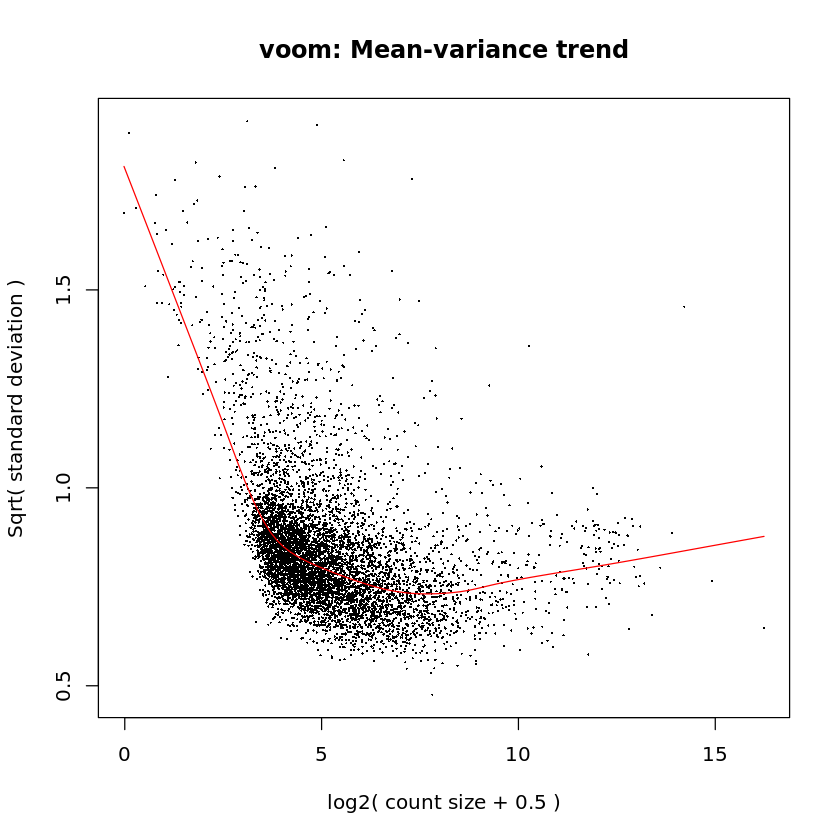

In [60]:
y <- voom(d, mm, plot = T)

# Fitting linear models in limma

In [61]:
fit <- lmFit(y, mm)
head(coef(fit))

,ground_truthmalignant,ground_truthnormal,age,sexmale,batchFeb,batchMay,batchNov,batchOct,batchSept,storagefrozen
FO538757.2,3.389483,3.247294,0.006498114,-0.13283555,-0.08846620,0.131943005,0.2255981,0.42101696,0.2701877,-0.3195944
NOC2L,4.481472,3.949424,0.002967410,-0.04827745,0.19441070,-0.084292520,-0.2600382,-0.05174146,-0.4720106,-0.2301541
ISG15,5.715383,5.249885,0.028186737,0.34666708,0.24563071,-0.731101143,-1.0067357,0.14634797,1.1144849,-1.4238609
TNFRSF18,2.844698,6.730540,-0.040786232,-1.02877336,-0.07453661,-0.474858380,0.3681005,-1.20879832,-1.4138064,1.1710903
TNFRSF4,5.742772,8.011393,-0.061749331,-1.30709111,0.22457218,-0.009216034,0.5050859,-0.76143885,-1.5915283,0.7646215
SDF4,5.145678,5.214760,-0.013299200,-0.49499377,0.07078885,0.755320162,-0.7971936,1.88732985,0.2958849,0.8042351


In [62]:
contr <- makeContrasts(ground_truthmalignant - ground_truthnormal, levels = colnames(coef(fit)))
contr

,ground_truthmalignant - ground_truthnormal
ground_truthmalignant,1
ground_truthnormal,-1
age,0
sexmale,0
batchFeb,0
batchMay,0
batchNov,0
batchOct,0
batchSept,0
storagefrozen,0


In [63]:
tmp <- contrasts.fit(fit, contr)


In [64]:
tmp <- eBayes(tmp)


In [65]:
top.table <- topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD19,-4.843479,1.231090465,-11.120479,7.035542e-14,3.712468e-10,21.29447
CTSH,-6.361957,2.808202233,-10.946982,1.138619e-13,3.712468e-10,20.97172
CD81,-4.756346,1.138568177,-10.717043,2.168167e-13,4.712872e-10,20.17573
ITGB2,-4.777711,0.743460079,-10.341006,6.309036e-13,1.028531e-09,19.09287
ELFN1-AS1,-3.974597,1.104939790,-9.740946,3.602697e-12,4.698637e-09,17.49375
HCST,-4.047785,3.399796296,-9.594500,5.550491e-12,5.239600e-09,17.23736
PRSS21,-5.238780,0.003690399,-9.590027,5.624475e-12,5.239600e-09,16.29658
PTPN22,-3.265952,1.357457578,-9.516732,6.990147e-12,5.697843e-09,16.93039
CCDC151,-3.701676,0.753336764,-9.417617,9.388817e-12,6.802720e-09,16.40294


In [66]:
top.table = top.table %>% mutate("neglogq"=-log10(adj.P.Val))

In [67]:
top.table = top.table %>% mutate("gene"=rownames(top.table))

In [84]:
top.table = top.table %>% mutate("significant"=ifelse(adj.P.Val<0.1, "true", "false"))

In [68]:
#num genes with q<0.1
top.table %>% filter(adj.P.Val<0.1) %>% nrow()

[1] 1208

In [69]:
#num genes with q<0.1 & absolute fc>1.5
top.table %>% filter(adj.P.Val<0.1 & abs(logFC)>log2(1.5)) %>% nrow()

[1] 764

In [70]:
#upregulated genes sorted by FC
top.table %>% filter(adj.P.Val<0.1) %>% arrange(-logFC) %>% head(10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,neglogq,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EDNRB,5.108412,-0.14875972,3.154987,3.024370e-03,3.371268e-02,-1.77574843,1.472207,EDNRB
TMEM52B,4.245525,2.64832919,4.559287,4.668883e-05,2.272074e-03,1.81298332,2.643578,TMEM52B
NLGN4X,3.954624,0.69500749,6.658292,5.318451e-08,1.195918e-05,8.30800614,4.922299,NLGN4X
IFIT1,3.927590,0.84447317,7.052447,1.486384e-08,4.038628e-06,9.55677073,5.393766,IFIT1
CCND1,3.917707,3.44520668,3.036625,4.172493e-03,4.030938e-02,-2.64506317,1.394594,CCND1
CNTN1,3.754206,0.48161156,4.204640,1.405597e-04,4.849683e-03,0.92059974,2.314287,CNTN1
NEB,3.748611,1.90739731,6.588334,6.674001e-08,1.403908e-05,8.11005828,4.852661,NEB
DKK1,3.642439,2.14477493,3.956533,2.989918e-04,7.924779e-03,0.07271307,2.101013,DKK1
RP11-395G23.3,3.593654,1.32040977,7.531858,3.195488e-09,1.225751e-06,11.02657272,5.911598,RP11-395G23.3


In [71]:
#downregulated genes sorted by fc
top.table %>% filter(adj.P.Val<0.1) %>% arrange(logFC) %>% head(10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,neglogq,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CTSH,-6.361957,2.808202233,-10.946982,1.138619e-13,3.712468e-10,20.971718,9.430337,CTSH
PPBP,-5.250231,-0.065864768,-8.194869,3.938719e-10,1.975722e-07,12.787545,6.704274,PPBP
PRSS21,-5.238780,0.003690399,-9.590027,5.624475e-12,5.239600e-09,16.296576,8.280702,PRSS21
CD19,-4.843479,1.231090465,-11.120479,7.035542e-14,3.712468e-10,21.294466,9.430337,CD19
ITGB2,-4.777711,0.743460079,-10.341006,6.309036e-13,1.028531e-09,19.092869,8.987783,ITGB2
CD81,-4.756346,1.138568177,-10.717043,2.168167e-13,4.712872e-10,20.175730,9.326714,CD81
KCNMA1,-4.709615,1.044001046,-8.345870,2.460097e-10,1.458390e-07,13.456877,6.836126,KCNMA1
S100A12,-4.461849,-0.332809993,-7.718061,1.767637e-09,7.684509e-07,11.328477,6.114384,S100A12
HLA-DQB1,-4.412834,1.914892888,-6.962222,1.988572e-08,5.186992e-06,9.257270,5.285084,HLA-DQB1


In [72]:
#top upregulated genes sorted by pvalue
top.table %>% filter(adj.P.Val<0.1 & logFC>log2(1.5)) %>% arrange(P.Value) %>% head(10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,neglogq,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RBFOX2,1.938328,2.5435697,9.359116,1.118111e-11,7.291200e-09,16.532531,8.137201,RBFOX2
RP11-395G23.3,3.593654,1.3204098,7.531858,3.195488e-09,1.225751e-06,11.026573,5.911598,RP11-395G23.3
STIM1,1.301394,1.8705132,7.484140,3.720853e-09,1.347982e-06,10.901402,5.870316,STIM1
IFIT1,3.927590,0.8444732,7.052447,1.486384e-08,4.038628e-06,9.556771,5.393766,IFIT1
NLGN4X,3.954624,0.6950075,6.658292,5.318451e-08,1.195918e-05,8.308006,4.922299,NLGN4X
NEB,3.748611,1.9073973,6.588334,6.674001e-08,1.403908e-05,8.110058,4.852661,NEB
GMPR,2.360426,1.2281831,6.451417,1.041310e-07,1.835238e-05,7.700781,4.736308,GMPR
TTF1,1.108474,2.6576918,6.213766,2.256349e-07,3.678413e-05,6.896117,4.434340,TTF1
LIPT1,1.364351,1.6112053,6.013246,4.334939e-07,6.281809e-05,6.320286,4.201915,LIPT1


In [79]:
#top downregulated genes sorted by pvalue
top.table %>% filter(adj.P.Val<0.1 & logFC<(-log2(1.5))) %>% arrange(P.Value) %>% head(10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,neglogq,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CD19,-4.843479,1.231090465,-11.120479,7.035542e-14,3.712468e-10,21.29447,9.430337,CD19
CTSH,-6.361957,2.808202233,-10.946982,1.138619e-13,3.712468e-10,20.97172,9.430337,CTSH
CD81,-4.756346,1.138568177,-10.717043,2.168167e-13,4.712872e-10,20.17573,9.326714,CD81
ITGB2,-4.777711,0.743460079,-10.341006,6.309036e-13,1.028531e-09,19.09287,8.987783,ITGB2
ELFN1-AS1,-3.974597,1.104939790,-9.740946,3.602697e-12,4.698637e-09,17.49375,8.328028,ELFN1-AS1
HCST,-4.047785,3.399796296,-9.594500,5.550491e-12,5.239600e-09,17.23736,8.280702,HCST
PRSS21,-5.238780,0.003690399,-9.590027,5.624475e-12,5.239600e-09,16.29658,8.280702,PRSS21
PTPN22,-3.265952,1.357457578,-9.516732,6.990147e-12,5.697843e-09,16.93039,8.244289,PTPN22
CCDC151,-3.701676,0.753336764,-9.417617,9.388817e-12,6.802720e-09,16.40294,8.167317,CCDC151


## save DE results to file

In [74]:
write.csv(top.table, "outputs/script4d/DE_results_limma.voom_malig.vs.normal_cntrl.age.sex.batch.vial_minpct0.05.csv", row.names=F)

In [76]:
#num genes with q<0.1 & absolute fc>1.5
write.csv(top.table %>% filter(adj.P.Val<0.1 & abs(logFC)>log2(1.5)), "outputs/script4d/DE_results_onlypassthresh_limma.voom_malig.vs.normal_cntrl.age.sex.batch.vial_minpct0.05.csv", row.names=F)

## save normalized pseudobulk data (normalized using TMM from voom) to file

In [525]:
write.csv(y$E, "outputs/script4d/pseudobulk_log2CPM_limmavoom_minpct0.05.csv", row.names=T)

## visualizations

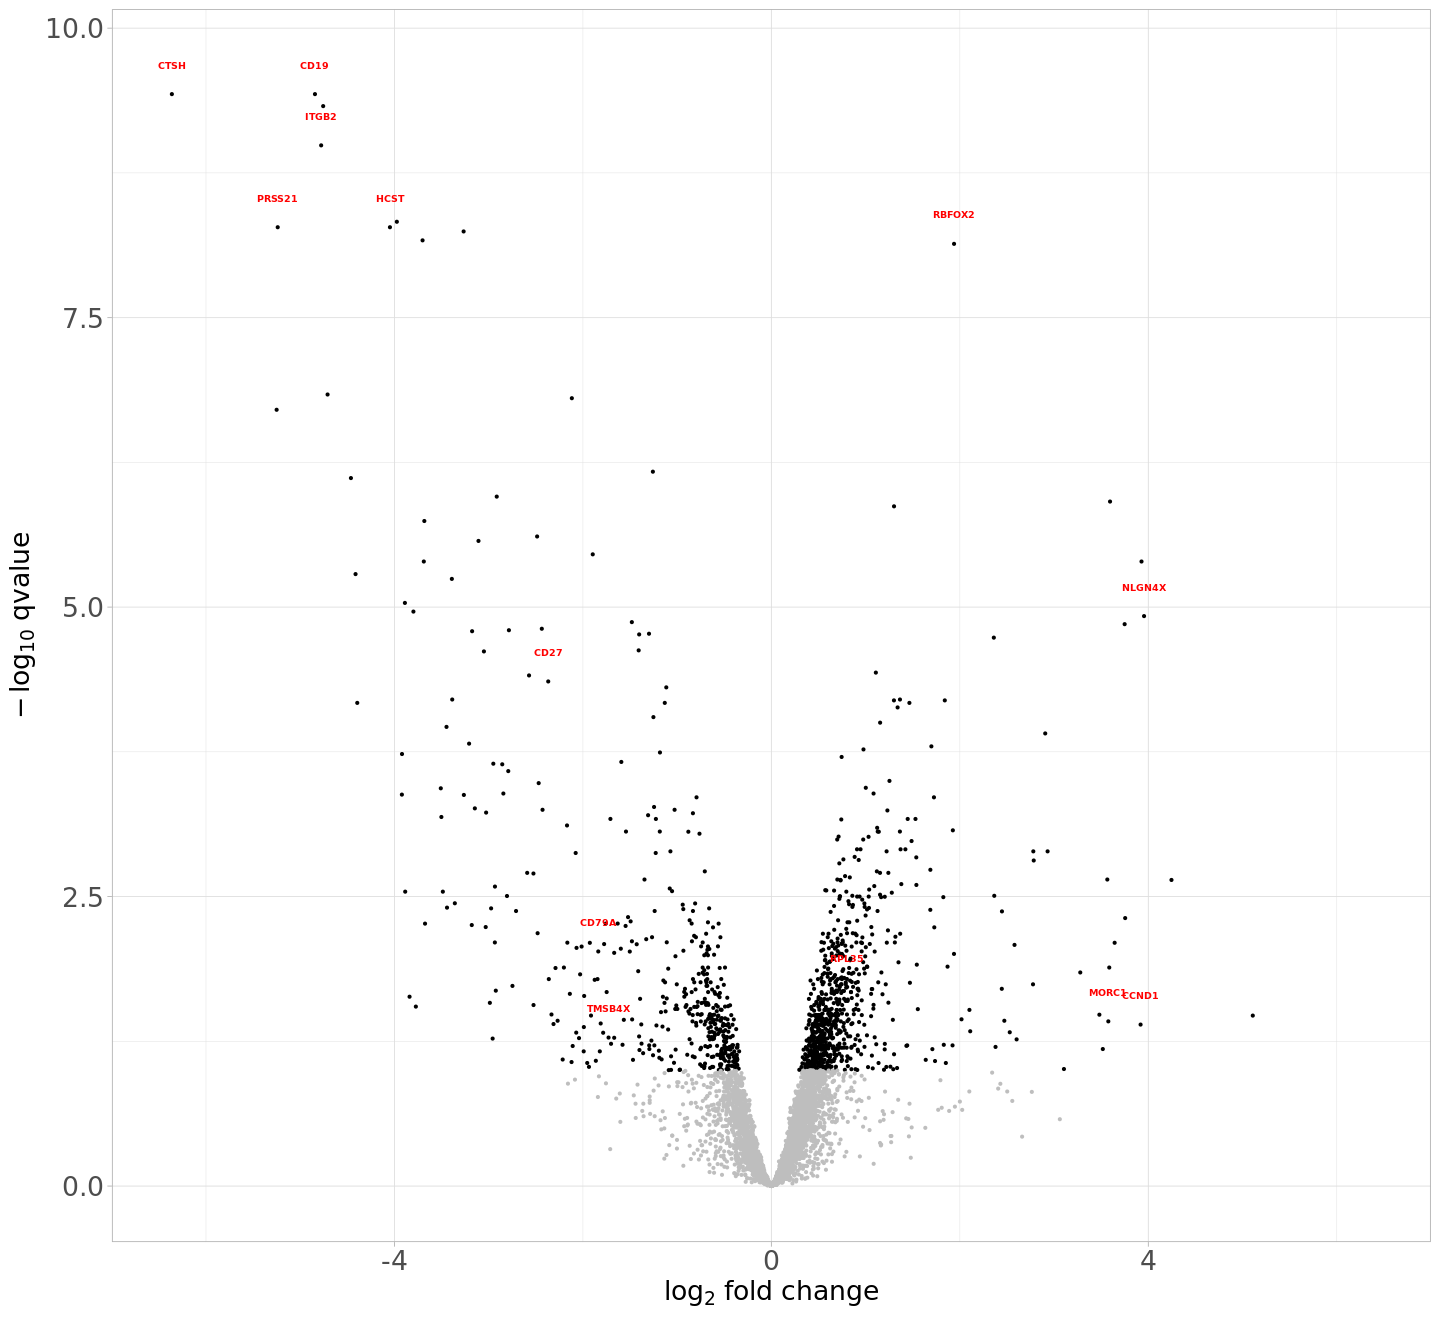

In [85]:
options(repr.plot.width=12, repr.plot.height=11)

ggplot(top.table, aes(x=logFC, y=neglogq)) + 
    geom_point(aes(color=significant), size=0.5) + scale_color_manual(values=c("grey", "black")) + 
    geom_text(aes(label=
                  ifelse(gene %in% c('CCND1','CCND2','HIST1H1C','CD27','TMSB4X',
                                     'CD79A','CTSH','HCST','FGFR3','WHSC1',
                                     'RPL35', 'ITM2C', 'LAMP5','TPT1',
                                     "MORC1","CCND1","NLGN4X","MGAT4C","RBFOX2",
                                     "CTSH","PRSS21","CD19","ITGB2") & 
                                        adj.P.Val<0.1 & abs(logFC)>abs(log2(1.5)),
                                        as.character(gene),'')),
              nudge_y=0.25,
              #position=position_jitter(width=.075,height=.075), 
              colour = "red", fontface="bold", size=2) + #
    xlim(-max(abs(top.table$logFC)),max(abs(top.table$logFC))) +
    theme_light() +
    xlab(expression(log[2]~fold~change)) +
    ylab(expression(-log[10]~qvalue)) +
    theme(axis.text=element_text(size=16),
          axis.title=element_text(size=16,face="bold"),
         legend.position = "none")
#ggsave("figures/script4d/limmavoom_volcanoplot.png", width = 5, height = 5)
#ggsave("figures/script4d/limmavoom_volcanoplot.pdf", width = 4, height = 4)

In [553]:
top.table = top.table %>% mutate("significant"=ifelse(adj.P.Val<0.1, "yes","no"))

In [572]:
library(pheatmap)

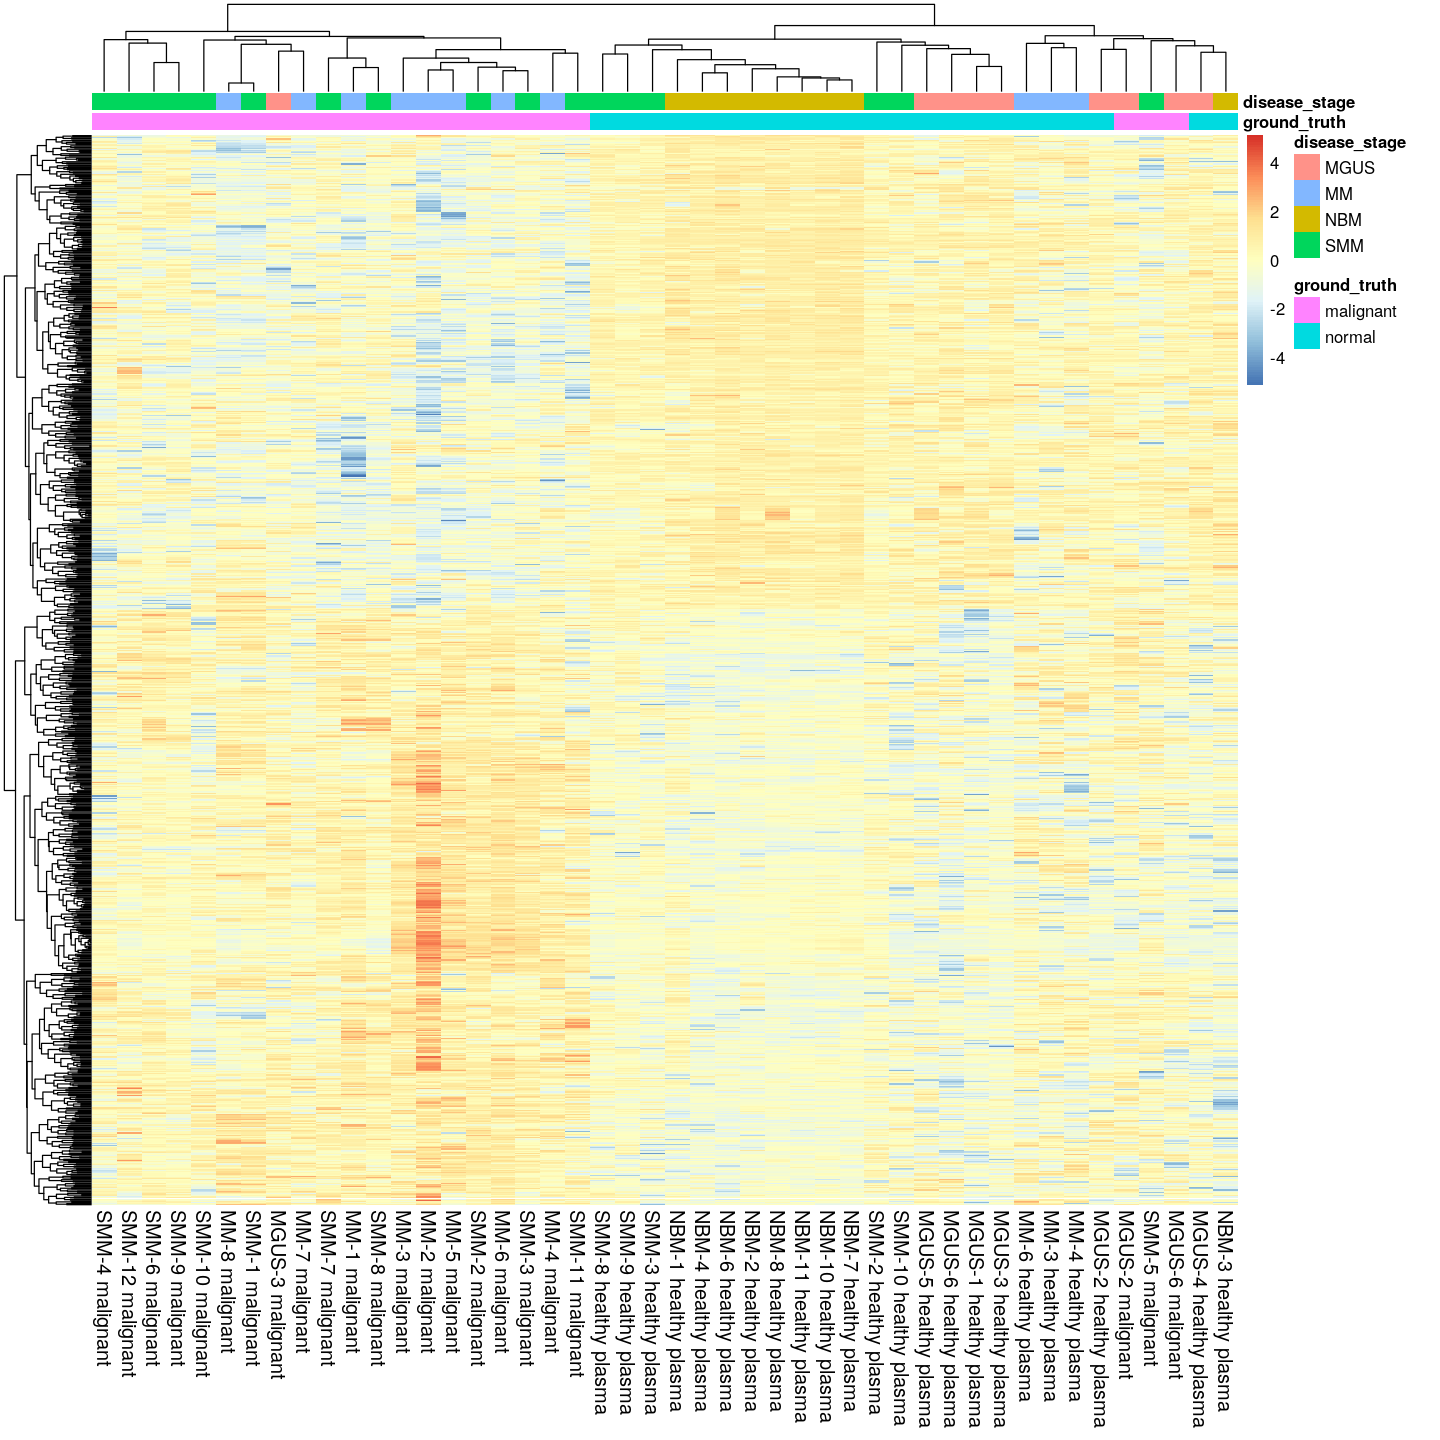

In [540]:
#using the built in correlation distance function -- for some reason gives less good separation of malignant
#and healthy samples so will stick with the above
options(repr.plot.width=12, repr.plot.height=12)

# Plot the heatmap
library("pheatmap")
pheatmap(
  y$E[(top.table %>% filter(adj.P.Val<0.1 & abs(logFC)>abs(log2(1.5))))$gene,],
    scale = "row", show_rownames=F, margins=c(14,0), fontsize_col=12,
    clustering_distance_cols = "correlation",
    clustering_distance_rows = "correlation",
    annotation_col=sample_info[,c("ground_truth","disease_stage")]
  )

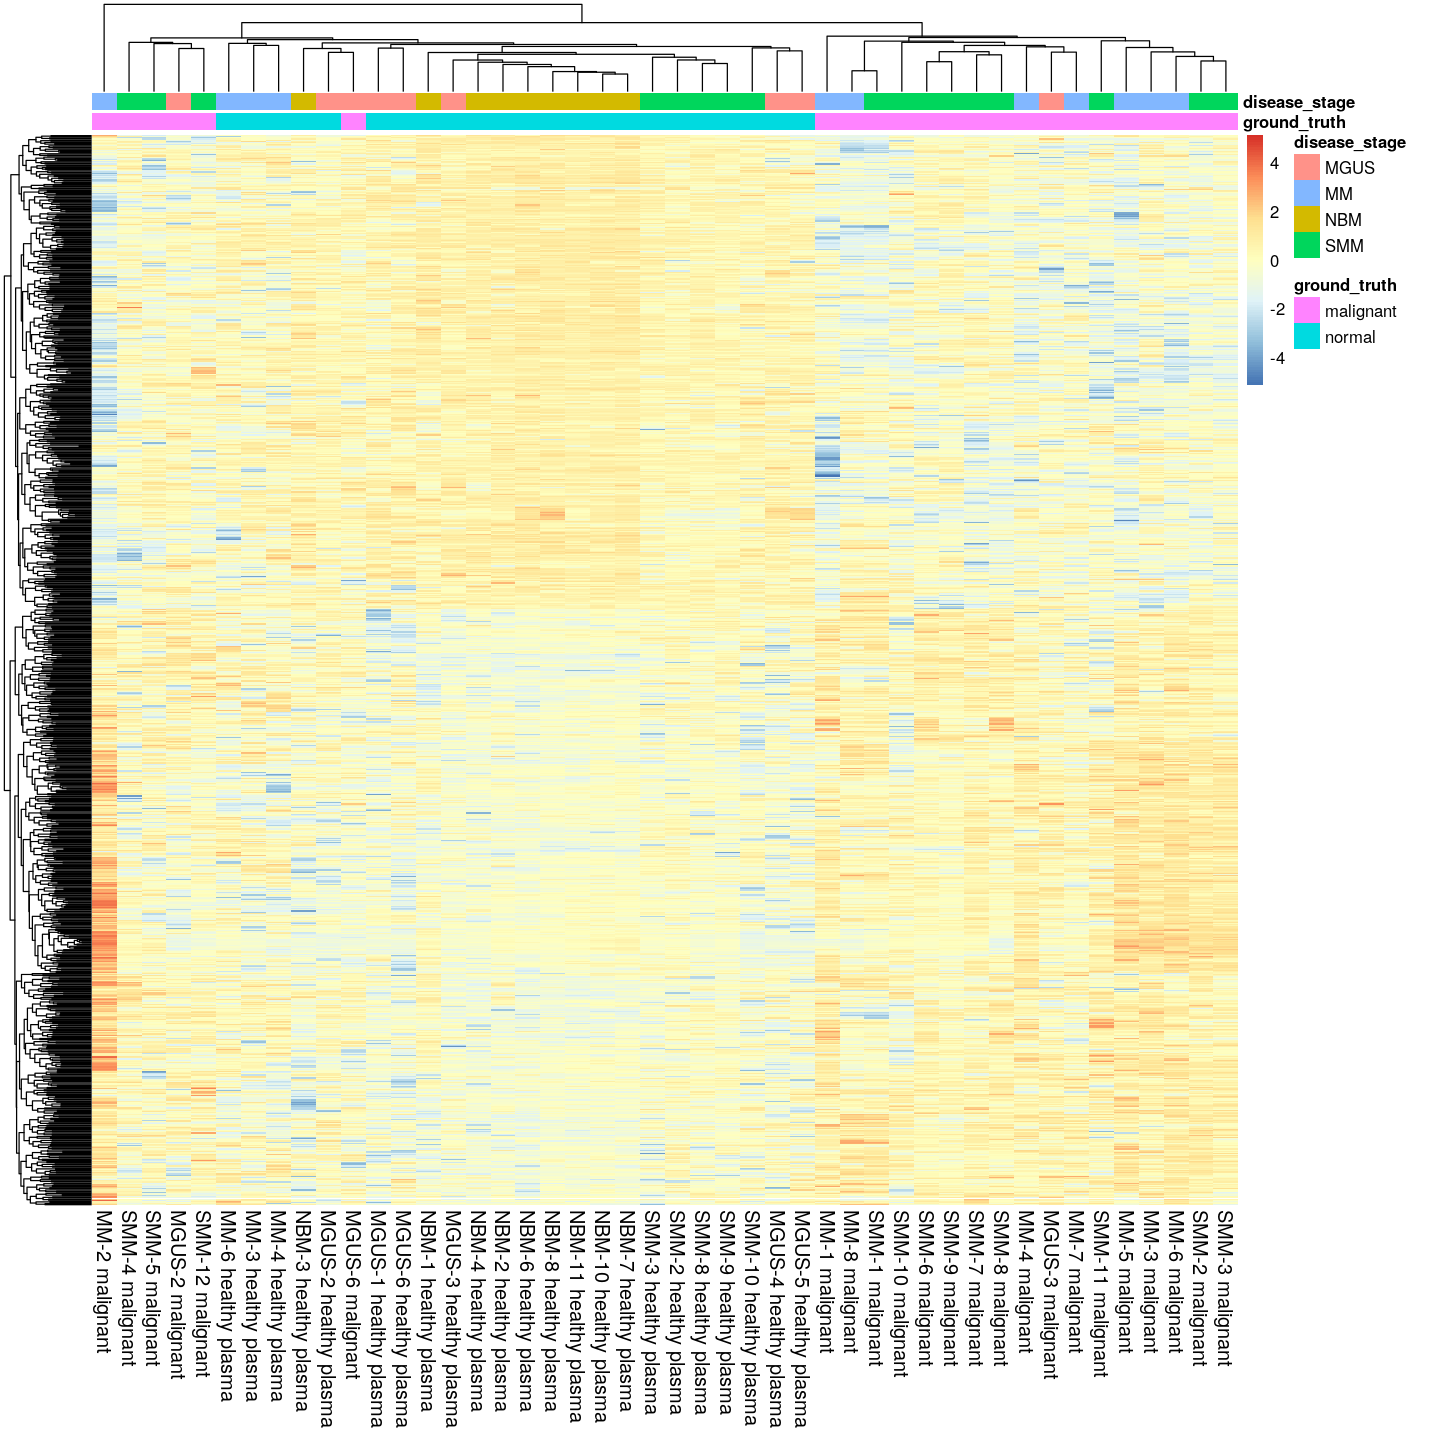

In [543]:
#using the built in correlation distance function -- for some reason gives less good separation of malignant
#and healthy samples so will stick with the above
options(repr.plot.width=12, repr.plot.height=12)

# Plot the heatmap
library("pheatmap")
pheatmap(
  y$E[(top.table %>% filter(adj.P.Val<0.1 & abs(logFC)>abs(log2(1.5))))$gene,],
    scale = "row", show_rownames=F, margins=c(14,0), fontsize_col=12,
    annotation_col=sample_info[,c("ground_truth","disease_stage")]
  )

# Jonckheere trend test - W16 sig activity in normal plasma cells across disease stages

In [4]:
person_mean_activity_long = read.csv("outputs/script5/person_mean_activity_long.csv")

In [10]:
totest = person_mean_activity_long %>% filter(ground_truth == "healthy plasma") %>% filter(signature=="W16")

In [13]:
totest$disease_stage <- ordered(totest$disease_stage, levels = c("NBM", "MGUS", "SMM", "MM"))

In [28]:
jonckheere.test(totest$mean_activity, totest$disease_stage, alternative = c("decreasing"))#, nperm=100000)


	Jonckheere-Terpstra test

data:  
JT = 24, p-value = 1.322e-05
alternative hypothesis: decreasing
